# Car ownership calibration 

This notebook contains the procedure to calibrate the auto ownership model. 

## TO DO LIST 
- Document functions 
- Describe process 
- Improve performance (now is taking about 5 minutes)

In [1]:
import numpy as np 
import pandas as pd 
import time
import orca 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 

from sklearn.model_selection import KFold, train_test_split
from statsmodels.discrete.discrete_model import MNLogit

## Function definition 

In [2]:
def simulation(probs):
    """
    Runs a Monte Carlo simulation given a probability distribution. 
    Input: 
    - probs: Array-like of probability distributions. 
             Each row is a different individual, 
             each column is possible choice. 
             
    Returns: Final choice. 
    
    Example input file: 
    
    ID.  CAR_0  CAR_1  CAR_2 
    1.    0.5    0.2    0.3
    2.    0.3    0.5    0.2
    """
    rands = np.random.rand(len(probs),1,)
    probs_arr = probs.values.cumsum(axis=1) - rands
    choices = np.argmax(probs_arr > 0.0, axis=1)
    choices = pd.Series(choices, index=probs.index)
    return choices

In [3]:
def run_car_ownership(values, coeffs):
    """
    Returns auto_ownership choice 
    1. Evaluate utilities 
    2. Calculate probabilities 
    3. Make choices (with simulation function)
    
    Input: 
    - Values: Attributes of the individaul 
    - Coeffs: Estimated coefficients in model specification
    
    Return: 
    - Final car ownership choice for each individual
    """
     
    utils = (values @ coeffs).astype(float)
    utils_exp = utils.apply(np.exp)
    probs = utils_exp.div(utils_exp.sum(axis = 1), axis = 0)
    choices = simulation(probs)
    return choices

In [4]:
def car_ownership_validation(hh):
    ''' 
    Validation tool for car ownership model. 
    Input: Dataframe with columns VEHCL: Real number of vehicles, 
           and 'auto_ownership': predicted household car ownership. 
    Output: Plots of carownership by TAZ, 
            and table with cars(real value), 
            auto ownership(modeled value), 
            and the difference. 
    '''
    # Auto ownership by TAZ 
    hh['0'] = hh['auto_ownership'] == 0
    hh['1'] = hh['auto_ownership'] == 1
    hh['2'] = hh['auto_ownership'] == 2
    hh['3'] = hh['auto_ownership'] == 3
    hh['4'] = hh['auto_ownership'] == 4

    auto_asim = hh.groupby('TAZ').agg({'0': 'sum','1': 'sum','2': 'sum','3': 'sum','4': 'sum' })
    auto_asim.reset_index(inplace = True)

    auto_asim = pd.melt(auto_asim, id_vars=['TAZ'], value_vars=['0', '1', '2', '3', '4'])
    
    #VEHCL by TAZ 
    hh['0'] = hh['VEHICL'] == 0
    hh['1'] = hh['VEHICL'] == 1
    hh['2'] = hh['VEHICL'] == 2
    hh['3'] = hh['VEHICL'] == 3
    hh['4'] = hh['VEHICL'] >= 4

    auto_tm1 = hh.groupby('TAZ').agg({'0': 'sum','1': 'sum','2': 'sum','3': 'sum','4': 'sum', })
    auto_tm1.reset_index(inplace = True)

    auto_tm1 = pd.melt(auto_tm1, id_vars=['TAZ'], value_vars=['0', '1', '2', '3', '4'])
    
    # Merge ativitysim and validation results in one table
    auto = auto_asim.merge(auto_tm1, how = 'inner', on = ['TAZ', 'variable'], suffixes=('_asim', '_tm1'))
    auto.columns = ['TAZ', 'Auto ownership', 'ActivitySim', 'True value']
    
    #Plot
    g = sns.lmplot('True value','ActivitySim', auto,col = 'Auto ownership',sharex = False,sharey = False,
               markers='o', height=5, aspect=0.8, x_jitter=.1, col_wrap=3,
              scatter_kws={"s": 20, "edgecolor": 'k', "alpha": 0.5})

    g.fig.suptitle("H3-to-H3 Car ownerwhip \n ActivitySim", y=1.05, fontsize = 15);

In [5]:
def add_simulation_vars(households, accessibilities, land_use):
    """
    Generate dataframe with the variables that are needed for simulation according to the model specification. 
    Input: 
    - Households: DataFrame with household table (Simulation resuls)
    - accessibilities: DataFrame. Accessibilities table (Simulation Result)
    - land_use: DataFrame. Land use table (Simulation result)
    
    Output: 
    - Dataframe with needed variables to simulate the car ownership model. 
    """
    #Merge accesibilities and land use variables 
    hh_merge = hh.merge(accessibilities, how = 'inner', left_on = 'TAZ', right_index = True).\
              merge(land_use, how = 'inner', left_on = 'TAZ', right_index = True)
    
    #Household-based variables 
    hh_merge['num_drivers_2'] = hh_merge.num_drivers == 2
    hh_merge['num_drivers_3'] = hh_merge.num_drivers == 3
    hh_merge['num_drivers_4+'] = hh_merge.num_drivers > 3
    hh_merge['children_0_4'] = hh_merge.num_young_children > 0
    hh_merge['children_5_17'] = (hh_merge.num_children_5_to_15 + hh_merge.num_children_16_to_17)>0
    hh_merge['num_workes_3'] = hh_merge.num_workers.clip(upper = 3)
    hh_merge['income_30'] = hh_merge.income_in_thousands.clip(0,30)
    hh_merge['income_75'] = (hh_merge.income_in_thousands-30).clip(0,45)
    hh_merge['income_125'] = (hh_merge.income_in_thousands-75).clip(0,50)
    
    #Household and land_use-based variables 
    hh_merge['density_10_0w'] = (hh_merge.num_workers == 0)*(hh_merge.density_index.clip(0,10))
    hh_merge['density_+10_0w'] = (hh_merge.num_workers == 0)*(hh_merge.density_index-10).clip(0)
    hh_merge['density_10_+1w'] = (hh_merge.num_workers > 0)*(hh_merge.density_index.clip(0,10))
    hh_merge['density_+10_+1w'] = (hh_merge.num_workers > 0)*(hh_merge.density_index-10).clip(0)
    hh_merge['constant'] = 1
    
    #Accessibility_based variables
    hh_merge['retail_0w_auto'] = (hh_merge.num_workers == 0)*(0.66*hh_merge.auPkRetail + 0.34*hh_merge.auOpRetail)
    hh_merge['retail_+1w_auto'] = (hh_merge.num_workers > 0)*(0.66*hh_merge.auPkRetail + 0.34*hh_merge.auOpRetail)
    hh_merge['retail_0w_transit'] = (hh_merge.num_workers == 0)*(0.66*hh_merge.trPkRetail + 0.34*hh_merge.trOpRetail)
    hh_merge['retail_+1w_transit'] = (hh_merge.num_workers > 0)*(0.66*hh_merge.trPkRetail + 0.34*hh_merge.trOpRetail)
    hh_merge['retail_0w_nm'] = (hh_merge.num_workers == 0)*hh_merge.nmRetail
    hh_merge['retail_+1w_nm'] = (hh_merge.num_workers > 0)*hh_merge.nmRetail
    hh_merge['auto_saving_work'] = np.where(hh_merge.num_workers > 0, 
                                      hh_merge.hh_work_auto_savings_ratio/hh_merge.num_workers, 
                                      0)
    
    hh_merge['cars'] = hh_merge.VEHICL.where(hh_merge.VEHICL < 4, 4)
    return hh_merge

In [6]:
def grid_search(vars_to_replace, coeff, hh_merge, var_names, iterations = 100):
    '''
    Grid-like search algortihm to estimate the best parameters to maximize prediction of car ownership share
    Input: 
    - var_to_replace: list of 12 arrays. Each array contains the range for each coefficient. 
                    List in the following order: 
                    0. Constant 1_car
                    1. Constant 2_car
                    2. Constant 3_car
                    3. Constant 4_car
                    4. driver_2 1_car
                    5. driver_2 2_car
                    6. driver_2 3_car
                    7. driver_2 4_car
                    8. driver_3 1_car
                    9. driver_3 2_car
                    10. driver_3 3_car
                    11. driver_3 4_car
    - coeff: The coefficients dataframe
    - hh_merge: choosers
    - var_name: should be coefficient indexes and all var should be in hh_merge
    - iteration: Number of random sets for the gris like-search (since there are a lot of options,I select some of them)
    
    Return 
    Dataframe with "iterations" amount of rows.
    Each row represents the result of one combination of the 12 varaibles, and the corresponding score. 
    '''
    #Generate random set of coefficients 
    sample_list = []
    for var in vars_to_replace:
        random_sample = np.random.choice(var, iterations, replace = True)
        sample_list.append(random_sample)

    grid_rands = np.array(sample_list).T
    
    # Run simulation for each random set 
    score_list = []
    row_list = ['constant','num_drivers_2','num_drivers_3']
    col_list = ['cars1', 'cars2', 'cars3','cars4']
    for row in grid_rands:
        
        #Replace random set coefficients 
        counter = 0 
        for row_coeff in row_list: 
            for col_coeff in col_list: 
                coeff.loc[row_coeff,col_coeff] = row[counter]
                counter += 1

        # Run model 
        choices = run_car_ownership(hh_merge[var_names], coeff)
        hh_merge['auto_ownership'] = choices 
        
        #Score
#         score = ((hh_merge['cars'] - hh_merge['auto_ownership'])**2).sum()/hh_merge.shape[0]
    #     score = sklearn.metrics.f1_score(hh_merge['cars'], hh_merge['auto_ownership'], average = 'weighted')
    #     cross_tab = pd.crosstab(hh_merge.VEHICL, hh_merge.auto_ownership, normalize= 'all')
    #     score = np.diagonal(cross_tab).sum()
        ## Loss Function
        score = np.abs((hh_merge.cars.value_counts() -  hh_merge.auto_ownership.value_counts())).sum()
        score_list.append(score)

    
    results_join = pd.DataFrame(grid_rands)
    results_join['score'] = score_list
    
    return results_join

In [7]:
def car_ownership_specs():
    """ Reads the specification for the auto ownership model"""
    var_names = ['num_drivers_2', 'num_drivers_3', 'num_drivers_4+', 'num_children_16_to_17',
             'num_college_age', 'num_young_adults', 'children_0_4', 'children_5_17',
             'num_workes_3', 'income_30', 'income_75', 'income_125', 'density_10_0w',
             'density_+10_0w','density_10_+1w', 'density_+10_+1w','constant', 
             'retail_0w_auto','retail_+1w_auto', 'retail_0w_transit','retail_+1w_transit', 
             'retail_0w_nm', 'retail_+1w_nm', 'auto_saving_work']


    # Read csv file 
    coeff_csv = pd.read_csv('configs/auto_ownership.csv')
    coeff = coeff_csv.fillna(0)[['cars0', 'cars1', 'cars2', 'cars3', 'cars4']]
    coeff.index = var_names
    return var_names, coeff, coeff_csv

In [8]:
def new_grid_ranges(grid_results):
    """ 
    Updates the new ranges for each variable for the next set of iterations
    Input: 
    - grid_results: Result table of the previous iteration (This table is generated by "grid_results" function)
    
    Output:
    - Array with the varaibles new grids values. 
    """
    
    #Order results from min to max score (we just want the 20th best scores for this)
    ordered = grid_results.sort_values('score').head(10)
    
    new_grid = []
    for i in range(12): #There are 12 variables that we are currently changing. 
        var_range = np.linspace(ordered[i].min(),ordered[i].max(),11)
        new_grid.append(var_range)
    
    assert len(new_grid) == 12
    
    return new_grid

In [9]:
def initialize_values():
    """ 
    Returns the initial settings for the grid serach algorithm and 
    the ranges of the coefficients subject to change. 
    
    Output: 
    - last_score: int: 9999999. Initial value for the loss function 
    - good_score: Default 1. Initial comparison between score previous and current iteration. 
                  1 means that the difference in the lost function between two subsequent iterations in 100%. 
    - iter_num: 0. Start counter at 0. Counts the number of iterations 
    - vars_to_replace: Initial set of values to start the grid serach algorithm. 
    """
    last_score = 9999999
    good_score = 1
    iter_num = 0

    var0 = np.linspace(0,5,11)
    var1 = np.linspace(0,5,11)
    var2 = np.linspace(-5,0,11)
    var3 = np.linspace(-5,0,11)

    # +-20% of the original coefficient. 
    var4 = np.linspace(-1,0,101)
    var5 = np.linspace(3.0773 - 0.47,3.0773 + 0.47,11)
    var6 = np.linspace(3.1962 - 0.48,3.1962 + 0.48,11)
    var7 = np.linspace(2.6616 - 0.40,2.6616 + 0.400,11)

    var8 = np.linspace(-2,0,11)
    var9 = np.linspace(3.5401 - 0.54,3.5401 + 0.54,11)
    var10 = np.linspace(5.513 - 0.83,5.5131 - 0.83,11)
    var11 = np.linspace(5.208 - 0.79,5.2080 + 0.79,11)

    vars_to_replace = [var0, var1, var2, var3, var4, var5, var6, var7, var8, var9, var10, var11]
    return last_score, good_score, iter_num, vars_to_replace

In [22]:
def grid_search_iterations(hh_merge, tolerance = 0.01, iterations = 50):
    """ Returns the best coefficients based on a grid search 
        and a updated hh_merge with the simulated car_ownership
        with the new best coefficients 
        
        Input: 
        - hh_merge: Pandas DataFrame: Data
        - tolerance: stoping point for the grid_search update. 
        - iterations: Iterations for each grid search. 
        """
    
    last_score, good_score, iter_num, vars_to_replace = initialize_values()
    var_names, coeff, coeff_csv = car_ownership_specs()
    
    #Run the iterations 
    
    while good_score > tolerance : 
        print(f"ITERATION: {iter_num}")
        #Run grid search 
        start = time.time()
        grid_results = grid_search(vars_to_replace, coeff, hh_merge, var_names, iterations = iterations)
        end = time.time()
        print(f"Runtime of the program is {end - start} seconds")

        #Get best score
        min_score = grid_results.score.min()
        print(f" Best score is: {min_score}")

        #Evalute best score reduction 
        good_score = np.abs((last_score - min_score)/last_score)
        print(f"The score reduction is: {good_score}%")

        #Update variables intervals
        vars_to_replace = new_grid_ranges(grid_results)

        #Replace last_score value
        last_score = min_score
        iter_num = iter_num + 1
        print ("")
    
    #TO ASK: Should I get the coefficients with the min score, 
    #or an average of the top10 (or more) coefficients. 
    best_coeffs = grid_results[grid_results.score == grid_results.score.min()]
    
    # Final choices 
    choices = run_car_ownership(hh_merge[var_names], coeff)
    hh_merge['auto_ownership'] = choices
    
    #replace coeficients in dataframa
    df_coeff = replace_coeffs_csv_file(coeff, best_coeffs)
    save_new_specs(coeff_csv, df_coeff)
    
    return best_coeffs, hh_merge

In [17]:
def replace_coeffs_csv_file(coeff, best_coeffs):
    """ Replaces the final coefficients in the spec csv file """
    new_coeff = coeff
    row_list = ['constant','num_drivers_2','num_drivers_3']
    col_list = ['cars1', 'cars2', 'cars3','cars4']
    
    counter = 0 
    for row in row_list: 
        for col in col_list: 
            new_coeff.loc[row,col] = best_coeffs.iloc[0,counter]
            counter += 1
    return  new_coeff

In [18]:
def save_new_specs(coeff_csv, coeff):
    """ Save the new specification in a csv file """
    print("Saving file ...")
    coeff.reset_index(inplace = True)
    var_list = ['cars0', 'cars1', 'cars2', 'cars3','cars4']
    
    for name in var_list:
        coeff_csv[name] = coeff[name]
    coeff_csv = coeff_csv.replace(0, np.nan)
    coeff_csv.to_csv('configs/auto_ownership_v2.csv', index = False)
    print("File saved")

## Data Processing 

In [19]:
hdf = pd.HDFStore('output/pipeline.h5')
pp = hdf['/persons/trip_mode_choice']
hh = hdf['/households/trip_mode_choice']
tours = hdf['/tours/trip_mode_choice']
trips = hdf['/trips/trip_mode_choice']
acc = hdf['/accessibility/trip_mode_choice']
lu = hdf['/land_use/trip_mode_choice']

print ('Number of Households: ',hh.shape[0])
print ('Number of Persons: ',pp.shape[0])
print ('Number of tours: ',tours.shape[0])
print ('Number of trips: ',trips.shape[0])

Number of Households:  50000
Number of Persons:  124225
Number of tours:  166999
Number of trips:  427373


## Grid search 
This part will take care of the grid search
- Create arrays for each parameter that will be included in the serach. Specify a lower and upper bound. 
- Built random combination sets of coefficients (All combinations take a lot to run) 
- Run simulation with random set of coefficients and store score result
- Organize scores in a table to compare results
- Replaces coefficients that resulted optimize score. 

In [20]:
%%time 
# Getting the right variables for simulation
hh_merge = add_simulation_vars(hh, acc, lu) 

#Grid Search 
best_coeffs, hh_merge = grid_search_iterations(hh_merge)

ITERATION: 0
Runtime of the program is 15.11326551437378 seconds
 Best score is: 9860
The score reduction is: 0.9990139999013999%

ITERATION: 1
Runtime of the program is 15.118415117263794 seconds
 Best score is: 5500
The score reduction is: 0.4421906693711968%

ITERATION: 2
Runtime of the program is 15.104017972946167 seconds
 Best score is: 3742
The score reduction is: 0.31963636363636366%

ITERATION: 3
Runtime of the program is 15.144341945648193 seconds
 Best score is: 3580
The score reduction is: 0.0432923570283271%

ITERATION: 4
Runtime of the program is 15.132735252380371 seconds
 Best score is: 2232
The score reduction is: 0.376536312849162%

ITERATION: 5
Runtime of the program is 14.971805572509766 seconds
 Best score is: 1664
The score reduction is: 0.25448028673835127%

ITERATION: 6
Runtime of the program is 15.003683805465698 seconds
 Best score is: 588
The score reduction is: 0.6466346153846154%

ITERATION: 7
Runtime of the program is 15.007718801498413 seconds
 Best score

    cars  auto_ownership  diff
2  21404           21682  -278
1  17905           17827    78
3   6656            6606    50
4   2182            2201   -19
0   1853            1684   169


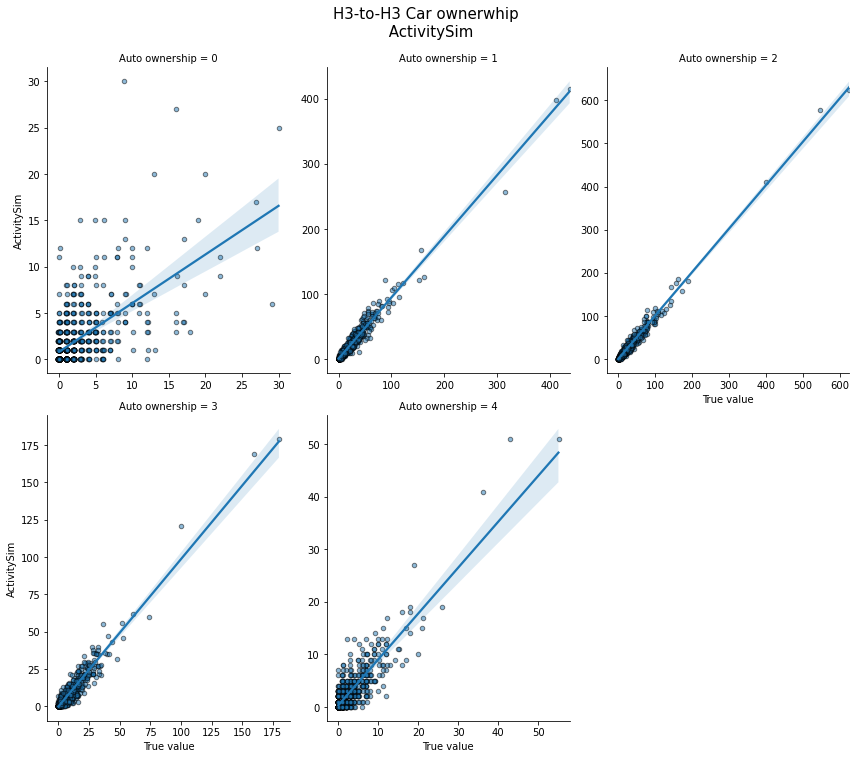

In [24]:
#Results
comparison = pd.concat((hh_merge['cars'].value_counts(), hh_merge['auto_ownership'].value_counts()), axis = 1)
comparison['diff'] = comparison['cars'] - comparison['auto_ownership']
print(comparison)
# print('-------------------------------------------------')
car_ownership_validation(hh_merge)